In [1]:
# midfusion_train_complete_fixed.py

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import resnet50
from torchvision.models._utils import IntermediateLayerGetter
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign
from torch.optim import AdamW
from tqdm import tqdm
import cv2
import numpy as np
from pathlib import Path

In [2]:
# ─── Dataset ────────────────────────────────────────────────────────────────────

class RGBDDetectionDataset(Dataset):
    def __init__(self, root: str, transforms=None):
        root = Path(root)
        self.rgb_paths  = sorted((root/"rgb").glob("*.*"))
        self.depth_dir  = root/"depth"
        self.label_dir  = root/"labels"
        self.transforms = transforms

    def __len__(self):
        return len(self.rgb_paths)

    def __getitem__(self, idx):
        rgb_path   = self.rgb_paths[idx]
        stem       = rgb_path.stem
        depth_path = self.depth_dir/f"{stem}.png"
        label_path = self.label_dir/f"{stem}.txt"

        # Load RGB
        img = cv2.imread(str(rgb_path), cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0  # H×W×3

        # Load Depth
        d = cv2.imread(str(depth_path), cv2.IMREAD_UNCHANGED).astype(np.float32)
        d /= (d.max() + 1e-6)                                               # H×W
        d = d[..., None]                                                     # H×W×1

        H, W = img.shape[:2]
        boxes = []
        if label_path.exists():
            with open(label_path) as f:
                for line in f:
                    cls, xc, yc, w, h = map(float, line.split())
                    x0 = (xc - w/2) * W; y0 = (yc - h/2) * H
                    x1 = (xc + w/2) * W; y1 = (yc + h/2) * H
                    boxes.append([x0, y0, x1, y1, int(cls)])
        if boxes:
            boxes = torch.tensor(boxes, dtype=torch.float32)
        else:
            boxes = torch.zeros((0,5), dtype=torch.float32)

        rgb_t   = torch.from_numpy(img.transpose(2,0,1))   # 3×H×W
        depth_t = torch.from_numpy(d.transpose(2,0,1))     # 1×H×W

        target = {
            "boxes":  boxes[:, :4],
            "labels": boxes[:, 4].long() + 1 # farterrcnn alwas take the 0th index as background so plus 1 for the shifting labels
        }

        if self.transforms:
            rgb_t, depth_t, target = self.transforms(rgb_t, depth_t, target)

        return rgb_t, depth_t, target

def collate_fn(batch):
    rgbs, depths, targets = zip(*batch)
    return list(rgbs), list(depths), list(targets)


In [3]:
# ─── Mid‐Level Fusion Backbone ─────────────────────────────────────────────────

class MidLevelFusionBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        # RGB ResNet50
        res_r = resnet50(pretrained=True)
        # Depth ResNet50 (single-channel)
        res_d = resnet50(pretrained=False)
        res_d.conv1 = nn.Conv2d(1, res_d.conv1.out_channels,
                                kernel_size=7, stride=2, padding=3, bias=False)

        return_layers = {"layer1":"c2", "layer2":"c3", "layer3":"c4", "layer4":"c5"}
        self.rgb_extractor   = IntermediateLayerGetter(res_r, return_layers)
        self.depth_extractor = IntermediateLayerGetter(res_d, return_layers)

        # FPN for concatenated features (C2–C5)
        in_chs = [256*2, 512*2, 1024*2, 2048*2]
        self.fpn = FeaturePyramidNetwork(in_channels_list=in_chs, out_channels=256)
        self.out_channels = 256

    def forward(self, x):
        # x may be a list of Tensors [4×H×W] or a single Tensor [B,4,H,W]
        if isinstance(x, (list, tuple)):
            x = torch.stack(x, dim=0)
        # now x: [B,4,H,W]
        rgb   = x[:, :3, :, :]
        depth = x[:, 3:4, :, :]

        feats_r = self.rgb_extractor(rgb)
        feats_d = self.depth_extractor(depth)
        fused   = {name: torch.cat([feats_r[name], feats_d[name]], dim=1)
                   for name in feats_r}
        return self.fpn(fused)

In [4]:
# ─── Model Factory ─────────────────────────────────────────────────────────────

def build_midfusion_fasterrcnn(num_classes: int):
    backbone = MidLevelFusionBackbone()

    # 4 FPN levels → one size and aspect_ratios tuple per level
    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,), (256,)),
        aspect_ratios=((0.5,1.0,2.0),) * 4
    )

    # ROI pooling on the 4 FPN maps: c2–c5
    roi_pool = MultiScaleRoIAlign(
        featmap_names=['c2','c3','c4','c5'],
        output_size=7,
        sampling_ratio=2
    )

    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pool
    )
    # Normalize 4th channel (depth) with zero-mean
    model.transform.image_mean = [0.485, 0.456, 0.406, 0.0]
    model.transform.image_std  = [0.229, 0.224, 0.225, 1.0]
    return model


In [5]:
# ─── Training & Early Stopping ─────────────────────────────────────────────────

def train_one_epoch(model, loader, optimizer, device, epoch):
    model.train()
    pbar = tqdm(loader, desc=f"Epoch {epoch} [train]", unit="batch")
    total = 0.0
    for rgbs, depths, targets in pbar:
        inputs = [torch.cat([r, d], dim=0).to(device)
                  for r, d in zip(rgbs, depths)]
        tgts = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(inputs, tgts)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += loss.item()
        pbar.set_postfix(train_loss=f"{loss.item():.4f}")
    pbar.close()
    return total / len(loader)

@torch.no_grad()
def eval_loss(model, loader, device):
    # keep train() so loss_dict is returned
    model.train()
    pbar = tqdm(loader, desc="[val]  ", unit="batch")
    total = 0.0
    for rgbs, depths, targets in pbar:
        inputs = [torch.cat([r, d], dim=0).to(device)
                  for r, d in zip(rgbs, depths)]
        tgts   = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss = sum(model(inputs, tgts).values()).item()
        total += loss
        pbar.set_postfix(val_loss=f"{loss:.4f}")
    pbar.close()
    return total / len(loader)


if __name__ == "__main__":
    # ── Hyperparameters ─────────────────────────────────────────────────────────
    ROOT_DIR    = "Processed_data"
    NUM_CLASSES = 6 + 1
    BATCH_SIZE  = 8
    LR          = 1e-4
    WD          = 1e-4
    MAX_EPOCHS  = 20
    PATIENCE    = 5
    VAL_SPLIT   = 0.2
    SEED        = 42
    DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # ──────────────────────────────────────────────────────────────────────────────

    ds    = RGBDDetectionDataset(ROOT_DIR)
    n_val = int(len(ds) * VAL_SPLIT)
    train_ds, val_ds = random_split(
        ds, [len(ds) - n_val, n_val],
        generator=torch.Generator().manual_seed(SEED)
    )
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=0, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=0, collate_fn=collate_fn)

    model     = build_midfusion_fasterrcnn(NUM_CLASSES).to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WD)

    best_val_loss     = float("inf")
    epochs_no_improve = 0

    for epoch in range(1, MAX_EPOCHS + 1):
        tr_loss = train_one_epoch(model, train_loader, optimizer, DEVICE, epoch)
        vl_loss = eval_loss(model, val_loader, DEVICE)

        print(f"Epoch {epoch:02d}: train_loss={tr_loss:.4f}, val_loss={vl_loss:.4f}")

        if vl_loss < best_val_loss:
            best_val_loss     = vl_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "midfusion_best1.pth")
            print("  ↳ Validation loss improved; model saved.")
        else:
            epochs_no_improve += 1
            print(f"  ↳ No improvement for {epochs_no_improve}/{PATIENCE} epochs.")
            if epochs_no_improve >= PATIENCE:
                print(f"Early stopping triggered at epoch {epoch}.")
                break

    print(f"Training complete. Best val_loss: {best_val_loss:.4f}")


f:\RGBD_Fusion\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\RGBD_Fusion\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
f:\RGBD_Fusion\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
[val]  : 100%|██████████| 33/33 [00:11<00:00,  2.87batch/s, val_loss=0.2074]


Epoch 01: train_loss=0.3002, val_loss=0.2055
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 33/33 [00:08<00:00,  3.98batch/s, val_loss=0.0969]


Epoch 02: train_loss=0.1405, val_loss=0.1197
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 33/33 [00:07<00:00,  4.13batch/s, val_loss=0.0923]


Epoch 03: train_loss=0.0990, val_loss=0.0939
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 33/33 [00:08<00:00,  3.70batch/s, val_loss=0.0908]


Epoch 04: train_loss=0.0793, val_loss=0.0868
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 33/33 [00:10<00:00,  3.14batch/s, val_loss=0.0713]


Epoch 05: train_loss=0.0662, val_loss=0.0738
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 33/33 [00:10<00:00,  3.25batch/s, val_loss=0.0642]


Epoch 06: train_loss=0.0586, val_loss=0.0676
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 33/33 [00:08<00:00,  3.84batch/s, val_loss=0.0663]


Epoch 07: train_loss=0.0541, val_loss=0.0735
  ↳ No improvement for 1/5 epochs.


[val]  : 100%|██████████| 33/33 [00:09<00:00,  3.33batch/s, val_loss=0.0590]


Epoch 08: train_loss=0.0494, val_loss=0.0639
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 33/33 [00:07<00:00,  4.15batch/s, val_loss=0.0425]


Epoch 09: train_loss=0.0472, val_loss=0.0606
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 33/33 [00:08<00:00,  4.11batch/s, val_loss=0.0529]


Epoch 10: train_loss=0.0438, val_loss=0.0563
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 33/33 [00:08<00:00,  3.74batch/s, val_loss=0.0452]


Epoch 11: train_loss=0.0415, val_loss=0.0580
  ↳ No improvement for 1/5 epochs.


[val]  : 100%|██████████| 33/33 [00:08<00:00,  3.71batch/s, val_loss=0.0417]


Epoch 12: train_loss=0.0416, val_loss=0.0531
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 33/33 [00:09<00:00,  3.46batch/s, val_loss=0.0348]


Epoch 13: train_loss=0.0403, val_loss=0.0564
  ↳ No improvement for 1/5 epochs.


[val]  : 100%|██████████| 33/33 [00:07<00:00,  4.17batch/s, val_loss=0.0335]


Epoch 14: train_loss=0.0344, val_loss=0.0509
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 33/33 [00:08<00:00,  3.93batch/s, val_loss=0.0467]


Epoch 15: train_loss=0.0310, val_loss=0.0525
  ↳ No improvement for 1/5 epochs.


[val]  : 100%|██████████| 33/33 [00:11<00:00,  2.89batch/s, val_loss=0.0323]


Epoch 16: train_loss=0.0306, val_loss=0.0500
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 33/33 [00:08<00:00,  4.09batch/s, val_loss=0.0314]


Epoch 17: train_loss=0.0312, val_loss=0.0487
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 33/33 [00:08<00:00,  3.67batch/s, val_loss=0.0467]


Epoch 18: train_loss=0.0295, val_loss=0.0536
  ↳ No improvement for 1/5 epochs.


[val]  : 100%|██████████| 33/33 [00:08<00:00,  3.87batch/s, val_loss=0.0352]


Epoch 19: train_loss=0.0283, val_loss=0.0459
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 33/33 [00:09<00:00,  3.58batch/s, val_loss=0.0406]

Epoch 20: train_loss=0.0339, val_loss=0.0562
  ↳ No improvement for 1/5 epochs.
Training complete. Best val_loss: 0.0459


f:\RGBD_Fusion\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\RGBD_Fusion\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
f:\RGBD_Fusion\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Evaluating: 100%|██████████| 66/66 [01:17<00:00,  1.17s/it]


Detection accuracy (IoU≥0.5): 97.88%



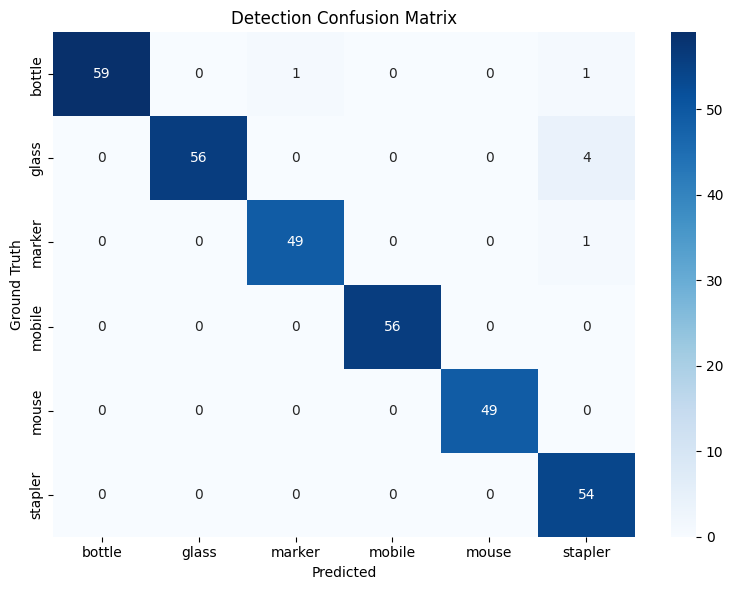

Overall detection accuracy: 97.88%


In [6]:
import torch
import numpy as np
import cv2
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# from midfusion_train_complete_fixed import build_midfusion_fasterrcnn, RGBDDetectionDataset, collate_fn
from torch.utils.data import DataLoader, random_split

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2]-boxA[0])*(boxA[3]-boxA[1])
    areaB = (boxB[2]-boxB[0])*(boxB[3]-boxB[1])
    union = areaA + areaB - inter
    return inter / union if union>0 else 0

def evaluate(model, loader, device,
             iou_thresh=0.5, score_thresh=0.5, label_map=None):
    gt_list, pred_list = [], []

    model.eval()
    with torch.no_grad():
        for rgbs, depths, targets in tqdm(loader, desc="Evaluating"):
            inputs = [torch.cat([r,d], dim=0).to(device)
                      for r,d in zip(rgbs, depths)]
            outputs = model(inputs)

            for out, tgt in zip(outputs, targets):
                gt_boxes  = tgt["boxes"].cpu().numpy()
                gt_labels = tgt["labels"].cpu().numpy()

                pred_boxes  = out["boxes"].cpu().numpy()
                pred_labels = out["labels"].cpu().numpy()
                pred_scores = out["scores"].cpu().numpy()

                keep = pred_scores >= score_thresh
                pred_boxes  = pred_boxes[keep]
                pred_labels = pred_labels[keep]

                if len(gt_boxes)==0 or len(pred_boxes)==0:
                    continue

                for gbox, glab in zip(gt_boxes, gt_labels):
                    ious = np.array([compute_iou(gbox, pbox)
                                     for pbox in pred_boxes])
                    best_j = ious.argmax()
                    if ious[best_j] >= iou_thresh:
                        gt_list.append(int(glab))
                        pred_list.append(int(pred_labels[best_j]))

    # overall accuracy
    acc = accuracy_score(gt_list, pred_list)
    print(f"\nDetection accuracy (IoU≥{iou_thresh}): {acc*100:.2f}%\n")

    # confusion matrix
    classes = list(label_map.keys())
    names   = [label_map[c] for c in classes]
    cm = confusion_matrix(gt_list, pred_list, labels=classes)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=names, yticklabels=names)
    plt.xlabel("Predicted")
    plt.ylabel("Ground Truth")
    plt.title("Detection Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # print accuracy again after the plot
    print(f"Overall detection accuracy: {acc*100:.2f}%")

if __name__ == "__main__":
    DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ROOT_DIR  = "Processed_data"
    WEIGHTS   = "midfusion_best1.pth"
    LABEL_MAP = {
        1: "bottle",
        2: "glass",
        3: "marker",
        4: "mobile",
        5: "mouse",
        6: "stapler"
    }

    # build model & load weights
    model = build_midfusion_fasterrcnn(num_classes=len(LABEL_MAP)+1)
    model.load_state_dict(torch.load(WEIGHTS, map_location=DEVICE))
    model.to(DEVICE)

    # val loader
    ds = RGBDDetectionDataset(ROOT_DIR)
    n_val = int(len(ds) * 0.2)
    _, val_ds = random_split(
        ds, [len(ds)-n_val, n_val],
        generator=torch.Generator().manual_seed(42)
    )
    val_loader = DataLoader(
        val_ds, batch_size=4, shuffle=False,
        num_workers=0, collate_fn=collate_fn
    )

    evaluate(model, val_loader, DEVICE,
             iou_thresh=0.5, score_thresh=0.5, label_map=LABEL_MAP)


In [7]:
# offline_inference.py

import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models import resnet50
from torchvision.models._utils import IntermediateLayerGetter
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork
import cv2
import numpy as np
from pathlib import Path
import torch
import cv2
import numpy as np
# from midfusion_train_complete_fixed import build_midfusion_fasterrcnn, RGBDDetectionDataset, collate_fn
from pathlib import Path

# ─── EDIT THESE ────────────────────────────────────────────────────────────────
RGB_PATH   = "Processed_data/rgb/20250718_122755_172682.jpg"
DEPTH_PATH = "Processed_data/depth/20250718_122755_172682.png"
WEIGHTS    = "midfusion_best1.pth" 
SCORE_THR  = 0.5
LABEL_MAP  = {1:"bottle",2:"glass",3:"marker",4:"mobile",5:"mouse",6:"stapler"}
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ───────────────────────────────────────────────────────────────────────────────

# Build model & load weights
model = build_midfusion_fasterrcnn(num_classes=len(LABEL_MAP)+1)
model.load_state_dict(torch.load(WEIGHTS, map_location=DEVICE))
model.to(DEVICE).eval()

# Load & fuse
rgb   = cv2.imread(RGB_PATH, cv2.IMREAD_COLOR)
rgb   = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
depth = cv2.imread(DEPTH_PATH, cv2.IMREAD_UNCHANGED).astype(np.float32)
depth = depth / (depth.max() + 1e-6)
fused = np.concatenate([rgb, depth[...,None]], axis=2)  # H×W×4

# To tensor and infer
inp = torch.from_numpy(fused.transpose(2,0,1)).to(DEVICE)
with torch.no_grad():
    pred = model([inp])[0]

# Draw results
vis = rgb.copy()
for box, score, cid in zip(pred["boxes"], pred["scores"], pred["labels"]):
    if score < SCORE_THR: continue
    x0,y0,x1,y1 = map(int, box.tolist())
    name = LABEL_MAP[int(cid)]
    cv2.rectangle(vis, (x0,y0), (x1,y1), (0,255,0), 2)
    cv2.putText(vis, f"{name}:{score:.2f}", (x0,y0-6),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

cv2.imshow("Inference", cv2.cvtColor(vis, cv2.COLOR_RGB2BGR))
cv2.waitKey(0)
cv2.destroyAllWindows()


f:\RGBD_Fusion\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\RGBD_Fusion\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
f:\RGBD_Fusion\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
# realsense_inference_fixed.py

import torch
import torch.nn as nn
import cv2
import numpy as np
import pyrealsense2 as rs

# fix imports
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign

# import your model factory
# from midfusion_train_complete_fixed import build_midfusion_fasterrcnn

# ─── EDIT THESE ────────────────────────────────────────────────────────────────
WEIGHTS    = "midfusion_best1.pth"
SCORE_THR  = 0.5
LABEL_MAP  = {1:"bottle",2:"glass",3:"marker",4:"mobile",5:"mouse",6:"stapler"}
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WIDTH,HEIGHT,FPS = 640,480,30
# ───────────────────────────────────────────────────────────────────────────────

# Build & load model
model = build_midfusion_fasterrcnn(num_classes=len(LABEL_MAP)+1)
state = torch.load(WEIGHTS, map_location=DEVICE)
model.load_state_dict(state)
model.to(DEVICE).eval()

# RealSense setup
pipe = rs.pipeline()
cfg  = rs.config()
cfg.enable_stream(rs.stream.depth, WIDTH, HEIGHT, rs.format.z16, FPS)
cfg.enable_stream(rs.stream.color, WIDTH, HEIGHT, rs.format.bgr8, FPS)
pipe.start(cfg)

try:
    while True:
        frames = pipe.wait_for_frames()
        d = frames.get_depth_frame(); c = frames.get_color_frame()
        if not d or not c: 
            continue

        # depth → normalized H×W
        depth = np.asanyarray(d.get_data()).astype(np.float32)
        depth = depth / (depth.max() + 1e-6)
        # color → BGR H×W×3
        color = np.asanyarray(c.get_data())

        # fuse into H×W×4 RGB+D
        rgb   = cv2.cvtColor(color, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
        fused = np.concatenate([rgb, depth[...,None]], axis=2)

        # to 4×H×W tensor
        inp = torch.from_numpy(fused.transpose(2,0,1)).unsqueeze(0).to(DEVICE)

        # inference
        with torch.no_grad():
            pred = model(inp)[0]

        # draw
        for box, score, cid in zip(pred["boxes"], pred["scores"], pred["labels"]):
            if score < SCORE_THR: 
                continue
            x0,y0,x1,y1 = map(int, box.tolist())
            name = LABEL_MAP[int(cid)]
            cv2.rectangle(color, (x0,y0), (x1,y1), (0,255,0), 2)
            cv2.putText(color, f"{name}:{score:.2f}", (x0,y0-6),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

        cv2.imshow("RealSense Live Detection", color)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

finally:
    pipe.stop()
    cv2.destroyAllWindows()
